# [LELEC2870] - Machine Learning

## Practical Session 5 - Feature selection 

Prof. Michel Verleysen (suppl. Dr. Cyril De Bodt)<br>
Prof. John Lee<br>

**Teaching assistants :**  
Edouard Couplet : edouard.couplet@uclouvain.be  <br>
Dany Rimez: dany.rimez@uclouvain.be<br>
Mathieu Simon: mathieu.simon@uclouvain.be<br>
Maxime Zanella: maxime.zanella@uclouvain.be<br>

#### Imports

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression as mutual_info
from sklearn.feature_selection import SequentialFeatureSelector

import warnings
warnings.filterwarnings('ignore')

## Introduction

In machine learning, we frequently deal with high dimensional data, i.e., datasets with many features. Here, a "feature" refers to an individual measurable property or characteristic of the phenomenon being modeled. These features are the building blocks upon which a model makes predictions. However, not all features are created equal, and some may contribute more significantly to the model's performance than others.

Feature selection is the process of choosing a subset of relevant features for building a model while discarding irrelevant and/or redundant ones. The goal of feature selection can be:
- improving model performance
- mitigating the risk of overfitting 
- reducing sensitivity to uninformative features
- lowering computational needs
- enhancing model interpretability

In this practical session, we will explore several different methods for feature selection.

## Dataset

We provide you with the California Housing Dataset. The target variable is the median house value. This dataset was derived from the 1990 U.S. census, using one row per census block group. A block group is the smallest geographical unit for which the U.S. Census Bureau publishes sample data. Here is a brief description of the different variables:
<div class="alert alert-warning">
    
**Input features**
    
1. **longitude**: a measure of how far west a block group is; a higher value is farther west

2. **latitude**: a measure of how far north a block group is; a higher value is farther north

3. **housing_median_age**: median age of a house within a block group; a lower number is a newer building

4. **total_rooms**: total number of rooms within a block group

5. **total_bedrooms**: total number of bedrooms within a block group

6. **population**: total number of people residing within a block group

7. **households**: total number of households, a group of people residing within a home unit, for a block group

8. **median_income**: tedian income for households within a block group (measured in tens of thousands of US Dollars)

9. **ocean_proximity**: location of the house block w.r.t ocean/sea
    
**Target**
       
10. **median_house_value**: median house value for households within a block group (measured in US Dollars)

</div>


In [3]:
# Load dataset
df = pd.read_csv('data/housing.csv') 
df = df.sample(frac=1, random_state=13).reset_index(drop=True) # shuffle data and reset index
df.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-119.08,35.34,15.0,1474.0,235.0,768.0,238.0,4.1528,130100.0,INLAND
1,-117.23,32.80,21.0,2429.0,579.0,1011.0,538.0,3.2250,229400.0,NEAR OCEAN
2,-116.15,34.14,18.0,3312.0,705.0,1251.0,512.0,3.0139,82600.0,INLAND
3,-122.37,41.41,28.0,1729.0,419.0,929.0,370.0,1.2700,53100.0,INLAND
4,-119.87,36.81,6.0,1891.0,341.0,969.0,330.0,4.6726,107800.0,INLAND
5,-119.89,34.44,25.0,2786.0,470.0,1669.0,462.0,5.5184,268300.0,NEAR OCEAN
6,-117.80,33.92,16.0,5819.0,986.0,2306.0,914.0,4.6315,277500.0,<1H OCEAN
7,-117.87,33.86,28.0,2292.0,531.0,2197.0,509.0,3.4856,142800.0,<1H OCEAN
8,-118.68,34.28,5.0,6150.0,1265.0,3188.0,1266.0,4.7034,223000.0,<1H OCEAN
9,-121.19,40.23,10.0,1572.0,232.0,247.0,104.0,5.8453,193800.0,INLAND


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


This datasets is not usable as such so we need to do a bit of preprocessing.

#### Missing values

It is quite common when facing a new dataset to notice missing values (NaN) that will prevent the proper training machine learning models. Here we can see that there are missing values for the "total_bedrooms" variable. A common solution to this problem is simply to drop the data samples containing NaNs (if there are not too many of them). Other more involved solutions are based on data imputation. Here we will go for the easy one ;)

In [5]:
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20433 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20433 non-null  float64
 1   latitude            20433 non-null  float64
 2   housing_median_age  20433 non-null  float64
 3   total_rooms         20433 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20433 non-null  float64
 6   households          20433 non-null  float64
 7   median_income       20433 non-null  float64
 8   median_house_value  20433 non-null  float64
 9   ocean_proximity     20433 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.7+ MB


#### Categorical variables

Some features may be expressed in formats that can not be processed directly by the model (mainly categorical features) and therefore must be expressed differently. It is the case here for the "ocean_proximity" feature.

We can simply use one-hot encoding and this would be fine. But perhaps we can also try to encode this variable in a more informed way. To understand how it categorizes the "proximity to the ocean", let us display this variable according to the spatial location given by the "longitude" and "latitude" variables:

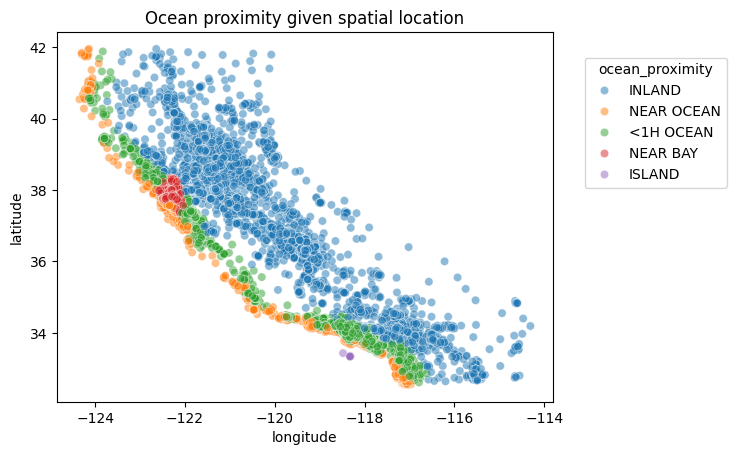

In [6]:
sns.scatterplot(
    data=df,
    x="longitude",
    y="latitude",
    hue="ocean_proximity",
    alpha=0.5,
)
plt.legend(title="ocean_proximity", bbox_to_anchor=(1.05, 0.95), loc="upper left")
_ = plt.title("Ocean proximity given spatial location")

We recognize the coast of California and can make several observations/decisions:

- there is very few "ISLAND" values, perhaps we can replace them with the "NEAR OCEAN" category
- there is a clear progression in the variables "NEAR OCEAN", "<1H OCEAN" and "INLAND" which we can account for using ordinal encoding. 
- the "NEAR BAY" variable indicates if samples are close to the bay area near San Francisco. This area lies within then "<1H OCEAN" strip so we can replace "NEAR BAY" by "<1H OCEAN" prior to the ordinal encoding. In order to keep the information related to the bay proximity, we can then create a new binary variable that indicates if a sample is near the bay or not.

In [7]:
# copy of dataset
data = df.copy()

# Modify column "ocean_proximity" using ordinal encoding
ocean_proximity_map = {"ISLAND":1, "NEAR OCEAN":1, "NEAR BAY":2, "<1H OCEAN":2, "INLAND":3}
data["ocean_proximity"] = df["ocean_proximity"].replace(ocean_proximity_map)

# Create new binary column "near_bay"
bay_proximity_map = {"NEAR BAY":1, "ISLAND":0, "NEAR OCEAN":0, "<1H OCEAN":0, "INLAND":0}
data["near_bay"] = df["ocean_proximity"].replace(bay_proximity_map)

data.head(10)

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,near_bay
0,-119.08,35.34,15.0,1474.0,235.0,768.0,238.0,4.1528,130100.0,3,0
1,-117.23,32.80,21.0,2429.0,579.0,1011.0,538.0,3.2250,229400.0,1,0
2,-116.15,34.14,18.0,3312.0,705.0,1251.0,512.0,3.0139,82600.0,3,0
3,-122.37,41.41,28.0,1729.0,419.0,929.0,370.0,1.2700,53100.0,3,0
4,-119.87,36.81,6.0,1891.0,341.0,969.0,330.0,4.6726,107800.0,3,0
5,-119.89,34.44,25.0,2786.0,470.0,1669.0,462.0,5.5184,268300.0,1,0
6,-117.80,33.92,16.0,5819.0,986.0,2306.0,914.0,4.6315,277500.0,2,0
7,-117.87,33.86,28.0,2292.0,531.0,2197.0,509.0,3.4856,142800.0,2,0
8,-118.68,34.28,5.0,6150.0,1265.0,3188.0,1266.0,4.7034,223000.0,2,0
9,-121.19,40.23,10.0,1572.0,232.0,247.0,104.0,5.8453,193800.0,3,0


#### Outliers

There is no precise definition for an outlier. It usually refers to a data point that differs significantly from other observations. Whether to discard outliers and how to handle them can depend on the nature of your data and the specific problem you're trying to solve. Here are some general considerations:

-  Check whether outliers are genuine data points or errors. Errors are not representative of the data and can be discarded straight away (even before train-test split). Genuine outliers might represent rare but valid instances in your data and should not be discarded without thoughtful consideration.

- Outliers among genuine data points should typically be identified and handled only in the training dataset. If you remove outliers before splitting your data into train and test sets, you risk data leakage. The test set should be representative of unseen data, and removing outliers from it could lead to overly optimistic performance estimates.

- When trying to identify outliers, make sure that the assumptions of your outlier detection method hold (e.g., if using z-scores, your data should be normally distributed otherwise detection may be biased). 

- Instead of outright discarding outliers, consider alternative strategies such as variable transformation (e.g., log transformation), capping extreme values, or using robust models that are less affected by outliers.

- In the end, evaluating your model's performance both with and without outlier handling (on a validation set for example) is probably the best way to understand the impact on generalization and make informed decision about the strategy to adopt.

We will thus first check if there are errors or not.


In [8]:
data.describe(percentiles=[0.05,0.95])

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,near_bay
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206864.413155,2.189057,0.111095
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115435.667099,0.641136,0.314257
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000,1.000000,0.000000
5%,-122.470000,32.820000,8.000000,622.000000,137.000000,348.000000,125.000000,1.600660,66260.000000,1.000000,0.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179700.000000,2.000000,0.000000
95%,-117.080000,38.960000,52.000000,6217.000000,1275.400000,3284.400000,1159.000000,7.300340,490560.000000,3.000000,1.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000,3.000000,1.000000


When comparing the 95th percentile value with the max value for all features, we can identify the presence of some extreme values in the data distributions but it does not seem like there is any measurement or data errors. We thus choose to keep all samples, and for sake of simplicty, we do not apply additional variable transformations (though it would be interesting to try out a log transformation on some of the variables). 

<div class="alert alert-info">
    <b>Remarks</b> <br>
This is a very basic outlier analysis; more rigorous tools for outliers analysis and outlier handling are available in the statistical literature (but it is not the main focus of the course).
</div> 

#### Train-Test split

Here we perform the usual train-test split to avoid bias when evaluating the model.

In [9]:
X = data.drop("median_house_value", axis=1) # predictor variables
y = pd.DataFrame(data["median_house_value"].copy()) # target variables

# Train-Test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# check sizes
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(16346, 10)
(4087, 10)
(16346, 1)
(4087, 1)


#### Standardization

Finally, we standardize the data. Standardization, also known as z-score normalization, brings all features to a similar scale. This can have several positive effects on various machine learning models. In particular, it is essential for algorithms that rely on distance measures (e.g., KNN, SVM), and is almost always beneficial for algorithms that rely on some form of gradient descent for parameter optimization (e.g., for neural networks, standardization can aid in faster convergence and improved training stability).
For decision trees, the impact of standardization is generally minimal.


In [10]:
# Standardize predictor variables
scX = StandardScaler()
scX.fit(X_train)
X_train = pd.DataFrame(scX.transform(X_train), columns=X_train.columns)
X_test = pd.DataFrame(scX.transform(X_test), columns=X_test.columns)

# Here we choose to standardize the target as well (not always useful)
scy = StandardScaler()
scy.fit(y_train)
y_train = pd.DataFrame(scy.transform(y_train), columns=y_train.columns)
y_test = pd.DataFrame(scy.transform(y_test), columns=y_test.columns)

Ok, now that the dataset is cleaned-up and ready, let's dive into feature selection!

## Feature selection

We will go through 3 different approaches to feature selection: filters, wrappers and embedded methods.

There is only 10 features in the preprocessed California Housing dataset so we will probably face the situation where selecting all the features gives the best performance, no matter what model/approach is used. However, imagine a scenario where you are constrained to use a very basic MLP:

In [11]:
# basic MLP
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)

Moreover, you can only use 5 features as input. Your goal is thus to find, for the given MLP, the best subset of size 5 among the 10 available features. Here "the best subset" is the one that leads to the lowest RMSE.

Bellow is a function for assesing the quality of your feature selection:

In [12]:
def evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features):
    
    # train model
    model.fit(X_train[selected_features].values, y_train.values.ravel())
    
    # evaluate model
    y_pred = model.predict(X_test[selected_features].values) 
    rmse = np.sqrt(np.mean((y_pred-y_test.values.ravel() )**2))
    
    print(f"selected features: ")
    for i,feature in enumerate(selected_features):
        print(f"- {feature}")
    print("----------------------------------")
    print(f"RMSE basic MLP: {rmse:5.3f}")


Let's test it using all features. This will serve as a reference

In [13]:
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, X_train.columns)

selected features: 
- longitude
- latitude
- housing_median_age
- total_rooms
- total_bedrooms
- population
- households
- median_income
- ocean_proximity
- near_bay
----------------------------------
RMSE basic MLP: 0.518


### 1) Filters

In the context of feature selection, a filter is a method that evaluates the relevance of individual features based on some criterion, then selects the best subset of features according to this relevance criterion. Filters operate independently from machine learning models. Features are selected one at a time, usually using a greedy iterative search. Here we will use simple relevance criterions such as correlation or mutual information, hence the iterative search boils down to selecting the top K features according to the chosen criterion (or selecting all features for wich the relevance score is above a chosen threshold).

<br>


<img src="./data/filter.png" width = "700">

<div class="alert alert-warning">
    <b>Question </b> <br>

What are the advantages and disadvantages of filters? 
</div>


#### Correlation filter

This filter uses correlation as the relevance criterion. Correlation assesses the **linear relationship** between two variables.
Features with high (absolute) correlation with the target are considered more relevant, while those with low or zero correlation may be deemed less informative.


<div class="alert alert-success">
    <b>Code </b> <br>
Implement a correlation filter by filling in the missing parts of the code
</div>


In [14]:
# number of features to select
n_features = 5

# correlation between each feature and the target
corr = X_train.corrwith(y_train["median_house_value"])

# feature selection 
###################
# INSERT CODE HERE

selected_features =  ["population"] # to modify
selected_features = list(corr.abs().sort_values(ascending=False)[:n_features].index)

###################
## TODO: based on correlation with the target, provide a list of the selected features names
    
# evaluation
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

selected features: 
- median_income
- ocean_proximity
- near_bay
- latitude
- total_rooms
----------------------------------
RMSE basic MLP: 0.609



<div class="alert alert-info">
    <b>Remarks on correlation </b> <br>

- Zero correlation **does not** imply independence
    
- Correlation **does not** imply causation
    
</div>

<img src="data/correlation_causation.jpg" width = "400">

#### Mutual Information filter

We also want a filter that is able to capture **nonlinear relationships**. For this we will use mutual information as the relevance criterion. Mutual information between two variables measures the amount of information that knowing the value of one provides about the other. High mutual information indicates a strong relationship/dependence. Hence, for feature selection, features that have high mutual information with the target variable are considered more relevant.

<div class="alert alert-warning">
    <b>Question </b> <br>

Can you explain what mutual information measures/represents? Does zero mutual information imply independence? Does mutual information imply causation? Do not hesitate to check equations on the web for further insights.
</div>






<div class="alert alert-success">
    <b>Code </b> <br>
Implement a mutual information filter by filling in the missing parts of the code
</div>


In [18]:
# number of features to select
n_features = 5

# mutual information between each feature and the target
mi = pd.Series(mutual_info(X_train.values, y_train.values.ravel()), index=X_train.columns)

# feature selection 
###################
# INSERT CODE HERE

selected_features =  ["population"] # to modify
selected_features = list(mi.sort_values(ascending=False)[:n_features].index)
# print(selected_features)
# print(mi)

###################
## TODO: based on mutual info with the target, provide a list of selected features names
    
# evaluation
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)


selected features: 
- longitude
- median_income
- latitude
- ocean_proximity
- total_rooms
----------------------------------
RMSE basic MLP: 0.606





#### Maximum relevance and minimum redundancy

The filters that we implemented in the previous cells select the top K most relevant features according to a given criterion. However, within the selected subset, some features may be redundant, e.g., if they are highly correlated with one another. In this case we may want to discard one of the redundant feature. This is known as the 'maximum relevance-minimum redundancy' principle. 

<div class="alert alert-success">
    <b>Code </b> <br>
Compute correlations between each pair of features and display a heatmap of the obtained correlation matrix (hint: use seaborn). Identify potential groups of redundant features.
</div>


<Axes: >

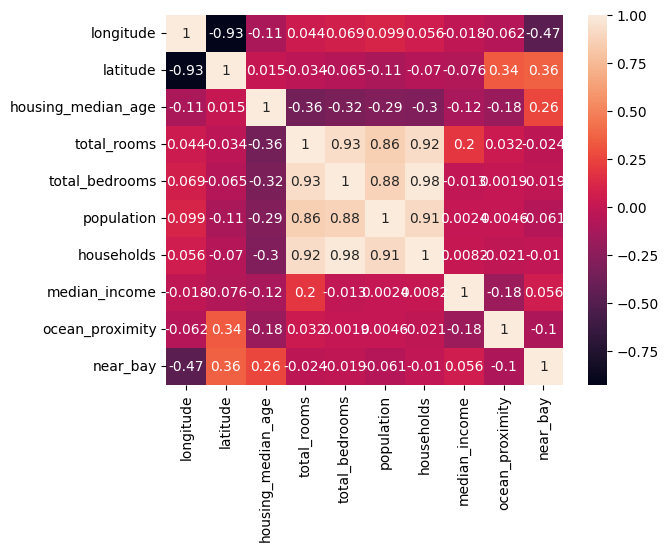

In [19]:
###################
# INSERT CODE HERE
train_corr = X_train.corr()
sns.heatmap(train_corr, annot=True)

###################
## TODO: plot a heatmap of pairwise correlations

<div class="alert alert-success">
    <b>Code </b> <br>
Read, understand and run the code bellow. We implement a filter with mutual information as the relevance criterion, and check for redundancy using correlation. Features are selected iteratively using a greedy search.
</div>



In [20]:
# number of features to select
n_features = 5

# relevance of features using mutual information with the target
mi = pd.Series(mutual_info(X_train.values, y_train.values.ravel()), index=X_train.columns)
ranked_features =  list(mi.sort_values(ascending=False).index)

# redundancy between variables will be assessed through correlations
corr = X_train.corr()

# define a correlation threhold above which two features are considered redundant
corr_threshold = 0.6
# initialize the list of selected features
selected_features = []

# iterate through the features, starting with the most relevant ones first
for feature in ranked_features:
    n_selected = len(selected_features)
    if n_selected==n_features:
        break # stop if we reach the desired number of features
    elif n_selected==0:
        selected_features.append(feature)
    else:
        feature_is_redundant = False
        # iterate through the already selected features and check for redundancy
        for selected_feature in selected_features:
            if np.abs(corr[feature][selected_feature])>corr_threshold:
                feature_is_redundant = True
                break
        if not feature_is_redundant:
            selected_features.append(feature)

            
# evaluation
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)           
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)          

selected features: 
- longitude
- median_income
- ocean_proximity
- total_rooms
- housing_median_age
----------------------------------
RMSE basic MLP: 0.578


<div class="alert alert-info">
<b> Remarks </b><br>
Discarding redundant features can be beneficial, e.g., for avoiding effects such as multicolinearity in Linear regression, or distances distortions for KNNs. However, in general, it can be tricky to judge whether it will be beneficial or not. For example, some important imformation for predicting the target could be contained in the difference between two highly correlated variables. The choice to remove redundant features or not is problem dependent; remember that feature selection should be guided by domain knowledge, the specific requirements of your model (in terms of performance, size, interpretability, etc), and thorough experimentation. It’s not a one-size-fits-all process.
</div>

### 2) Wrappers

Unlike filter methods, which rely on statistical measures to rank and select features before the model training process, wrapper methods use the performance of a specific machine learning algorithm as a criteria for feature selection. As with filters, we can use a greedy search to iteratively build a relevant subset of features.

<br>

<br>

<img src="data/wrapper.png" width = "700">

<div class="alert alert-warning">
    <b>Question </b> <br>
What are the advantages and disadvantanges of wrappers?
</div>


#### Forward search

Features are added one at a time, and at each step, the feature that provides the most improvement in model performance is selected. This procedure is carried on until a stopping criterion is met (when adding a feature increases the generalization error, when a desired number of features is obtained, etc).

<br>

<img src="data/forward.png" width = "400">

<br>

<div class="alert alert-success">
    <b>Code </b> <br>
Implement a wrapper using a forward greedy search. Fill in the missing parts of the code (hint: use scikit-learn's SequentialFeatureSelector).
</div>

In [24]:
# number of features to select
n_features = 5

# estimator that will be used in the wrapper
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)

# feature selection
###################
# INSERT CODE HERE
# forward search
selector = SequentialFeatureSelector(estimator=model, n_features_to_select=n_features, direction="forward", scoring="neg_mean_squared_error", cv=2)
selector.fit(X_train, y_train.values.ravel())
selected_features = X_train.columns[selector.get_support()]

# selected_features = ["population"] # to modify

###################
## TODO: forward search 

#evaluation
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)  

selected features: 
- housing_median_age
- total_bedrooms
- population
- median_income
- ocean_proximity
----------------------------------
RMSE basic MLP: 0.551


#### Backward search

All features are initially included, and at each step, the least important feature is removed. This procedure is carried on until a stopping criterion is met (when removing a feature increases the generalization error, when a desired number of features is obtained, etc).

<br>

<img src="data/backward.png" width = "400">

<br>

<div class="alert alert-success">
    <b>Code </b> <br>
Implement a wrapper using a backward greedy search. Fill in the missing parts of the code (hint: use scikit-learn's SequentialFeatureSelector).
</div>

In [25]:
# number of features to select
n_features = 5

# estimator that will be used in the wrapper
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)

# feature selection
###################
# INSERT CODE HERE
# backward search
selector = SequentialFeatureSelector(estimator=model, n_features_to_select=n_features, direction="backward", scoring="neg_mean_squared_error", cv=2)
selector.fit(X_train, y_train.values.ravel())
selected_features = X_train.columns[selector.get_support()]

# selected_features = ["population"] # to modify

###################
## TODO: backward search 

#evaluation
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)  

selected features: 
- longitude
- latitude
- total_bedrooms
- population
- median_income
----------------------------------
RMSE basic MLP: 0.548


<div class="alert alert-warning">
    <b>Question </b> <br>

What are the advantages and disadvantages of forward search vs backward search?
</div>


<div class="alert alert-info">
    <b>Remarks </b> <br>
    
- Many variants of forward and backward search can be designed! For example, we could consider both backward and forward options at each step of the search.

- We can also design more complex relevance and/or stopping criterions to obtain subsets of features with desired characteristics. 
    
    
Feel free to explore different approaches in your project, but keep in mind the computational load!
</div>


### 3) Embedded methods

An embedded method refers to an approach where feature selection is an integral part of the process of training  a machine learning model. Unlike wrapper methods, which evaluate feature subsets based on the model's performance, embedded methods incorporate feature selection directly into the model training process. These methods optimize both the feature selection and the model parameters simultaneously. 


An example are decision trees: they inherently perform feature selection during the tree-building process by selecting the most informative features for splitting nodes. 

When we train a decision tree, we get feature importances "for free":


In [26]:
# Train decision tree
dt = DecisionTreeRegressor(max_depth=10)
dt.fit(X_train, y_train)

# Evaluate model
y_pred = dt.predict(X_test)
rmse = np.sqrt(np.mean((y_pred-y_test.values.ravel())**2))

# Retrieve feature importances
feature_importances = pd.Series(dt.feature_importances_, index=X_train.columns)

print("Feature importances:")
for feature,feature_importance in feature_importances.items():
    print(f"- {feature:20} {feature_importance:5.3f}")
print("--------------------------------------")
print(f"Decision tree RMSE: {rmse:5.3f}")

Feature importances:
- longitude            0.098
- latitude             0.113
- housing_median_age   0.033
- total_rooms          0.009
- total_bedrooms       0.005
- population           0.009
- households           0.005
- median_income        0.544
- ocean_proximity      0.184
- near_bay             0.000
--------------------------------------
Decision tree RMSE: 0.527


Note that these feature importances do not necessarily transfer to other models. To see this, We can evaluate the performance of our MLP using the top K most important features as given by the decision tree:

In [27]:
# number of features to select
n_features = 5

# feature selection
selected_features = list(feature_importances.sort_values(ascending=False)[:n_features].index)

#evaluation
model = MLPRegressor(hidden_layer_sizes=(16), max_iter=25)
evaluate_feature_selection(X_train, X_test, y_train, y_test, model, selected_features)

selected features: 
- median_income
- ocean_proximity
- latitude
- longitude
- housing_median_age
----------------------------------
RMSE basic MLP: 0.581


Of course, Decision trees are not the only algorithms that integrate feature selection as part of the learning process; this is also the case for most algorithms based on decision trees, such as random forests or the more powerful XGBoost.  Other algoritmhs are also popular embedded methods: LASSO, Ridge regression, Elastic net, etc.